# $P(< D | E > E_\rm{th})$
The probability that a UHECR is detected from within a distance $D$, given that it is detected with an energy $\hat{E} > E_\rm{th}$. Both cases including and excluding the typical detection uncertainties for the UHECR energies.  
<br>
<br>
*This code was used to make Figure 3 in Capel & Mortlock (2019).*


In [1]:
import numpy as np
from scipy import integrate
import h5py

from matplotlib import pyplot as plt
plt.style.use(['minimalist', 'blues'])

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Simulating the cosmic ray propagation

In order to show the effect of including the detection uncertainties on the effective GZK horizon, we use the simple model for the propagation of protons as described in the paper. In this way, the results are directly relevant for the model which is later used to fit the data.

To find $P(< D | E > E_\rm{th})$ we use Bayes theorem to express this in terms of something that we can calculate through simulations. We have

$$
P(< D | E > E_\rm{th}) = \int_0^{D} dD' \ P(D' | E > E_\rm{th}),
$$
where
$$
P(D | E > E_\rm{th}) \propto P(D) \ P(E > E_\rm{th} | D).
$$

We calculate $P(E > E_\rm{th} | D)$ and $P(\hat{E} > E_\rm{th} | D)$ using simulations. The same <tt>Stan</tt> code as is used in the main model (see `uhecr_E_loss.stan`) is used for consistency and a python script using <tt>MPI</tt> (see `uhecr_E_loss.py`) is used to run many simulations in parallel on HPC services. These scripts can be rerun, but we include the output used in the paper as an hdf5 file (see `simulation_output/`) to show the results here.
<br>
<br>
The script was run with the following parameters:
* $\alpha = 2$
* $E_\rm{th}^\rm{sim} = 20 \ \rm{EeV}$
* $E_\rm{th} = 52 \ \rm{EeV}$

We simulate down to $E_\rm{th}^\rm{sim} = 20 \ \rm{EeV}$ in order to account for lower energy UHECR events being scattered above the detection threshold by the detection process. 

In [2]:
# Run the simulation script (command line)
# $ mpirun -n XX python uhecr_E_losses.py

## Read simulation ouput

In [3]:
# Simulation inputs and outputs are stored in the same file
with h5py.File('output/paper_uhecr_E_loss_output.h5', 'r') as f:

    # inputs (to check)
    Eth = f['Eth'].value
    Eth_sim = f['Eth_sim'].value
    alpha = f['alpha'].value
    Ds = f['Ds']
    Ncr = f['Ncr'].value
    Ntrials = f['Ntrials'].value
    f_E = f['f_E'].value
    
    # Results
    Parr = f['Parr'].value # arrival energy > Eth
    Pdet = f['Pdet'].value # detected energy > Eth
    D = f['D'].value

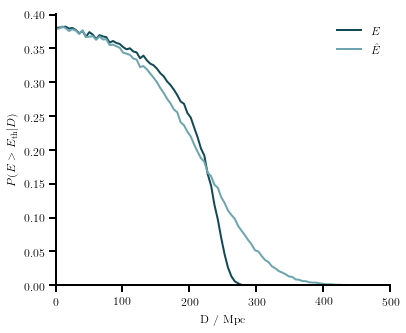

In [4]:
# Plot to show
fig, ax = plt.subplots()
fig.set_size_inches((6, 5))
ax.plot(D, Parr, label = '$E$')
ax.plot(D, Pdet, label = '$\hat{E}$')
ax.set_ylim(0)
ax.set_xlabel('D / Mpc')
ax.set_ylabel('$P(E > E_\mathrm{th} | D)$')
ax.legend();

## Find $P(< D | E > E_\rm{th})$

In [5]:
P_E_D = Parr 
P_Edet_D = Pdet 

# Bayes rule (P(D) ~ D^2)
P_D_E = D**2 * P_E_D
P_D_Edet = D**2 * P_Edet_D

# Normalisation
P_D_E = P_D_E / integrate.simps(P_D_E, D)
P_D_Edet = P_D_Edet / integrate.simps(P_D_Edet, D)

# Cumulative distribution
c_P_D_E = integrate.cumtrapz(P_D_E, D, initial = 0)
c_P_D_Edet = integrate.cumtrapz(P_D_Edet, D, initial = 0)

## Figure 3

/Users/fran/projects/bayes/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


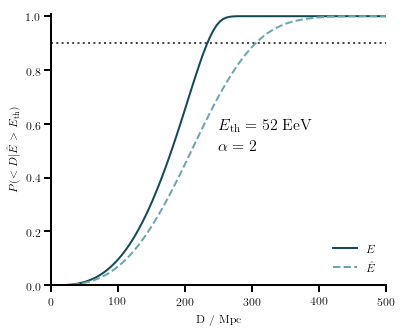

In [6]:
from fancy.plotting.colours import darkgrey

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

ax.plot(D, c_P_D_E, label = '$E$')
ax.plot(D, c_P_D_Edet, label = '$\hat{E}$', linestyle = '--')
ax.axhline(0.9, color = darkgrey, linestyle = ':')

ax.set_ylim(0, 1.01)
ax.set_xlabel('D / Mpc')
ax.set_ylabel('$P(< D | \hat{E} > E_\mathrm{th})$')
ax.text(250, 0.5, '$E_\mathrm{th} = 52$ EeV \n $\\alpha = 2$', fontsize = 16)
ax.legend();